# Resposta

## Introdução

A Petróleo Brasileiro S.A. (PETROBRAS), é uma empresa de energia que tem entre as suas principais atividades a produção e o refino de petróleo. Dentro de sua estrutura organizacional, existem diversas unidades de negócios, que são responsáveis pela exploração e produção em áreas geográficas distintas. A unidade de negócios do Espírito Santo (UN-ES) da PETROBRAS contempla diversas unidades estacionárias de produção (UEPs) ou plataformas de produção de petróleo localizadas em alto mar nas bacias do Espírito Santo e na bacia de Campos. A Bacia de Campos possui mais de 40 anos de existência, tempo no qual já foram produzidos 14 bilhões de barris de óleo e gás (boe) acumulados. A região responde atualmente por cerca de 30% de toda a produção nacional. Com 25 unidades em produção, essa bacia ocupa uma área que vai do Espírito Santo, na altura de Vitória, até Arraial do Cabo, no litoral norte do Rio de Janeiro. São cerca de 280 poços produtores em operação, aproximadamente 7 mil colaboradores trabalhando nas mais diversas frentes de atuação e 25 plataformas marítimas em operação – que produzem tanto no pós-sal quanto no pré-sal. Essas plataformas possuem diversos equipamentos que sofrem com o uso e as intempéries e dependem de rotinas de manutenção preventiva para que se mantenham em operação. Para gerenciar a rotina de manutenção dos milhares de equipamentos das plataformas é utilizado o módulo PM do sistema SAP. Nele são registrados planos de manutenção que geram periodicamente ordens de manutenção (OMs) com instruções específicas para a execução de manutenções preventivas.
Mensalmente são executadas auditorias em uma amostra das ordens de manutenção executadas na UN-ES e essas auditorias são geridas pelo Sistema de Análise de Ordens (SAO).

## Definição do problema

Todos os meses é feita auditoria por amostragem nas ordens de manutenção executadas nas plataformas da UN-ES. Um dos motivos de realizar essa auditoria por amostragem é que a auditoria manual de todas as ordens de manutenção consumiria muito tempo. A proposta deste trabalho é criar um programa que possa ser rodado sobre todas as ordens de manutenção e que consiga elencar, com base no texto longo de cada uma, quais ordens possuem grande probabilidade de possuir não conformidade.

## Descrição do conjunto de dados

Para o trabalho em questão são usados dados de ordens de manutenção que já foram avaliadas manualmente. De forma a simplificar as análises, foram coletadas informações sobre ordens relativas a apenas uma plataforma, a P-62. Essa plataforma foi escolhida pois nela os executantes usam computadores portáteis (PDAs) e realizam o preenchimento digital das informações nas ordens de manutenção, que posteriormente são transferidas de volta para o sistema SAP. Essas informações estão contidas na coluna "TELO_TX_LINHA" do arquivo CSV. Os resultados das análises de cada ordem é obtido a partir do banco de dados do sistema SAO e estão contidos na coluna "Gravidade" do arquivo CSV. O conjunto de dados utilizado no presente trabalho possui 2275 exemplos, como pode ser observado no DataFrame.

## Conclusões e discussões

É realizada a divisão dos dados entre treino e teste

In [1]:
import pandas as pd

X_train_new = pd.read_excel("TF-IDF_X_train.xlsx", index_col = "NumOrdem")
X_test_new = pd.read_excel("TF-IDF_X_test.xlsx", index_col = "NumOrdem")
y_train = pd.read_excel("TF-IDF_y_train.xlsx", index_col = "NumOrdem")
y_test = pd.read_excel("TF-IDF_y_test.xlsx", index_col = "NumOrdem")

Posteriormente é treinado um modelo do tipo random forest para predição da classe.

In [2]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, n_jobs = -1)
rf.fit(X_train_new, y_train.nc.tolist())

y_pred = rf.predict(X_test_new)

In [3]:
confusion_matrix = pd.crosstab(y_test.nc.tolist(), y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0   1
Actual            
0          349  10
1           23  17


In [4]:
from sklearn.metrics import classification_report
print(classification_report(y_test.nc.tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       359
           1       0.63      0.42      0.51        40

    accuracy                           0.92       399
   macro avg       0.78      0.70      0.73       399
weighted avg       0.91      0.92      0.91       399



É possível observar que o recall para a classe 1 é muito mais baixo que a precisão, o que indica uma grande quantidade de falsos negativos. Uma explicação possível é que, devido ao fato de existirem muitos mais exemplos da classe 0 que da classe 1, o modelo é enviesado e tende a atribuir os exemplos à classe 0. Uma proposta de trabalho futuro seria tentar contornar o desbalanceamento de classes e observar se os resultados melhoram.

## t-SNE

Modelo obtido da [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

<AxesSubplot:xlabel='0', ylabel='1'>

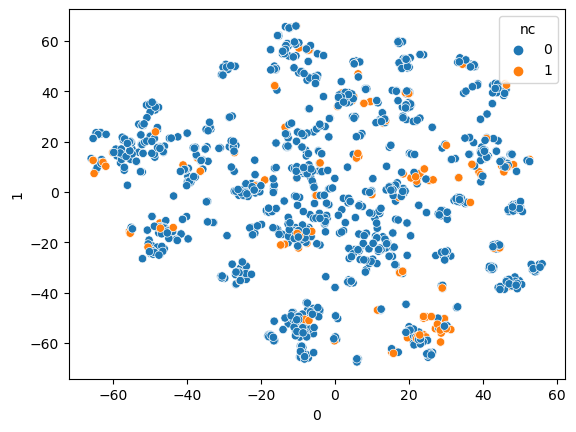

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=20).fit_transform(X_train_new)
X_embedded.shape
dfe = pd.DataFrame(X_embedded, index = X_train_new.index)
dfe = pd.concat([dfe, y_train], axis=1)
sns.scatterplot(data=dfe, x=0, y=1, hue="nc")

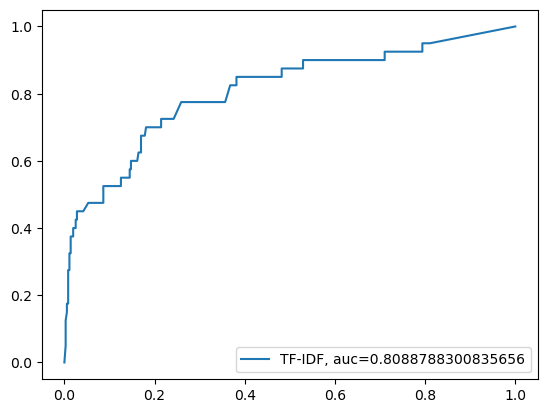

In [6]:
y_pred = rf.predict_proba(X_test_new)[::,1]
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="TF-IDF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### SMOTE

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = "minority")
X_sm, y_sm = smote.fit_resample(X_train_new, y_train)
y_sm.value_counts()


nc
0     1433
1     1433
dtype: int64

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, n_jobs = -1)
rf.fit(X_sm, y_sm)

y_pred = rf.predict(X_test_new)

confusion_matrix = pd.crosstab(y_test.nc.tolist(), y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test.nc.tolist(), y_pred))

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\588599852.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_sm, y_sm)


Predicted    0   1
Actual            
0          331  28
1           18  22
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       359
           1       0.44      0.55      0.49        40

    accuracy                           0.88       399
   macro avg       0.69      0.74      0.71       399
weighted avg       0.90      0.88      0.89       399



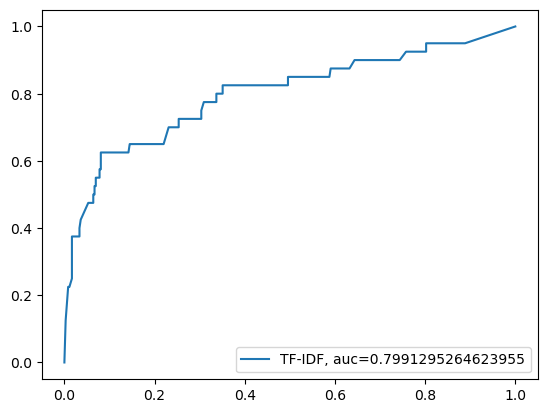

In [9]:
y_pred = rf.predict_proba(X_test_new)[::,1]
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="TF-IDF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Função para treino de modelos e geração de relatórios

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def report(tipo, y_pred_r, modelo, augment):
    print( 64*"X", "\n", tipo, " ", modelo, " ", str(augment), "\n", 63*"-" )
    confusion_matrix = pd.crosstab(y_test.nc.tolist(), np.rint(y_pred_r), rownames=['Actual'], colnames=['Predicted'])
    print("Matriz de confusão\n\n", confusion_matrix, "\n", 63*"-")
    print("Relatório de classificação\n\n", classification_report(y_test.nc.tolist(), np.rint(y_pred_r)), 63*"-")    


def train(tipo, dimensoes, arquivo, augment):

    # Pré processamento de dados

    df_fun_completo = pd.read_excel(arquivo, index_col = "NumOrdem").dropna(subset = ["TELO_TX_LINHA"])
    df_fun_completo.index = df_fun_completo.index.astype(int)
    X_train_fun = df_fun_completo[range(dimensoes)].loc[y_train.index.tolist()]
    X_test_fun = df_fun_completo[range(dimensoes)].loc[y_test.index.tolist()]
    if augment:
        smote = SMOTE(sampling_strategy = "minority")
        X_train_fun, y_train_fun = smote.fit_resample(X_train_fun, y_train)
    else:
        y_train_fun = y_train

    # Random forest

    rf_fun = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, n_jobs = -1)
    rf_fun.fit(X_train_fun, y_train_fun)
    y_pred_fun_rf = rf_fun.predict_proba(X_test_fun)[::,1]
    report(tipo, y_pred_fun_rf, "RF", augment)

    # Rede neural

    model = Sequential()
    model.add(Dense(64, activation = 'relu', input_dim=dimensoes))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_fun, y_train_fun, epochs=10, batch_size=32)
    y_pred_fun_nn = model.predict(X_test_fun)
    report(tipo, np.transpose(y_pred_fun_nn)[0], "NN", augment)

    # XGBoost

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", max_depth = 10, n_estimators = 200, random_state=0)
    xgb_model.fit(X_train_fun, y_train_fun)
    y_pred_fun_xgb = xgb_model.predict_proba(X_test_fun)[::,1]
    report(tipo, y_pred_fun_xgb, "XGBoost", augment)

    from sklearn.metrics import roc_curve, auc
    # Curva ROC

    y_true1 = y_test.nc.tolist()
    y_score1 = y_pred_fun_rf

    # Dados para a segunda curva ROC
    y_true2 = y_test.nc.tolist()
    y_score2 = y_pred_fun_nn

    # Dados para a terceira curva ROC
    y_true3 = y_test.nc.tolist()
    y_score3 = y_pred_fun_xgb

    # Calcula a curva ROC para a primeira curva
    fpr1, tpr1, _ = roc_curve(y_true1, y_score1)
    roc_auc1 = auc(fpr1, tpr1)

    # Calcula a curva ROC para a segunda curva
    fpr2, tpr2, _ = roc_curve(y_true2, y_score2)
    roc_auc2 = auc(fpr2, tpr2)

    # Calcula a curva ROC para a segunda curva
    fpr3, tpr3, _ = roc_curve(y_true3, y_score3)
    roc_auc3 = auc(fpr3, tpr3)

    # Plota as curvas ROC
    plt.figure()
    plt.plot(fpr1, tpr1, color='navy', lw=2, label='RF (AUC = %0.3f)' % roc_auc1)
    plt.plot(fpr2, tpr2, color='green', lw=2, label='NN (AUC = %0.3f)' % roc_auc2)
    plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='XGBoost (AUC = %0.3f)' % roc_auc3)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

## GPT

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 GPT   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          353    6
1           31    9 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.92      0.98      0.95       359
           1       0.60      0.23      0.33        40

    accuracy                           0.91       399
   macro avg       0.76      0.60      0.64       399
weighted avg       0.89      0.91      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 3s 34ms/step - loss: 0.3917 - accuracy: 0.8984
Epoch 2/10
50/50 [==============================] - 1s 25ms/step - loss: 0.3231 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 1s 27ms/step 

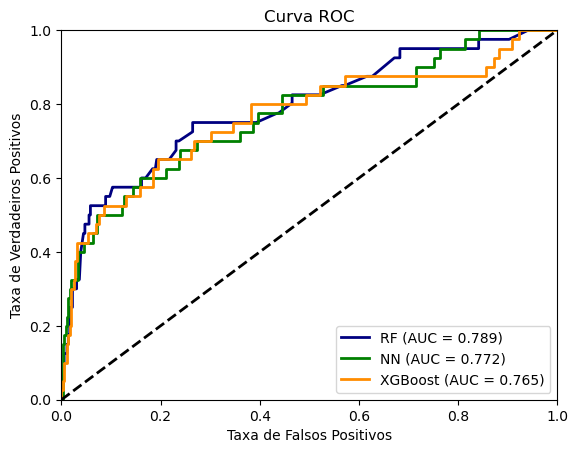

In [11]:
train(tipo = "GPT", dimensoes = 1536, arquivo = "GPT.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 GPT   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          348   11
1           23   17 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.94      0.97      0.95       359
           1       0.61      0.42      0.50        40

    accuracy                           0.91       399
   macro avg       0.77      0.70      0.73       399
weighted avg       0.90      0.91      0.91       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 2ms/step - loss: 0.6266 - accuracy: 0.6622
Epoch 2/10
90/90 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.7676
Epoch 3/10
90/90 [==============================] - 0s 3ms/step - lo

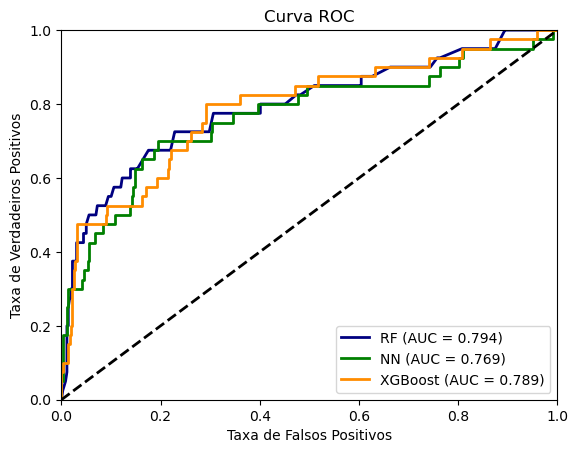

In [12]:
train(tipo = "GPT", dimensoes = 1536, arquivo = "GPT.xlsx", augment = True)

## BERTimbau

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 BERTimbau   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          354    5
1           33    7 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.91      0.99      0.95       359
           1       0.58      0.17      0.27        40

    accuracy                           0.90       399
   macro avg       0.75      0.58      0.61       399
weighted avg       0.88      0.90      0.88       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8928
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3034 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s 1ms/st

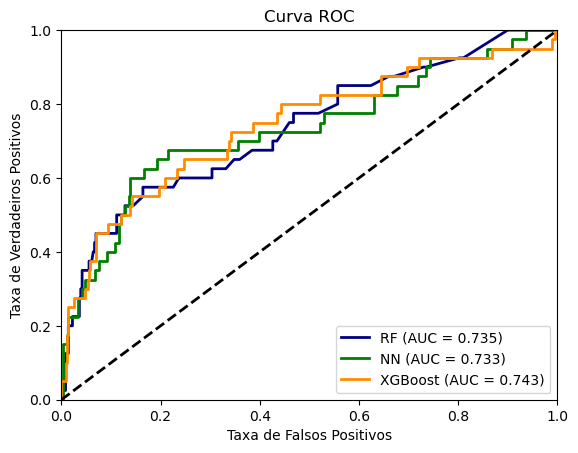

In [13]:
train(tipo = "BERTimbau", dimensoes = 768, arquivo = "BERT.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 BERTimbau   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          348   11
1           28   12 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.93      0.97      0.95       359
           1       0.52      0.30      0.38        40

    accuracy                           0.90       399
   macro avg       0.72      0.63      0.66       399
weighted avg       0.89      0.90      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.6029 - accuracy: 0.6622
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4856 - accuracy: 0.7652
Epoch 3/10
90/90 [==============================] - 0s 1ms/ste

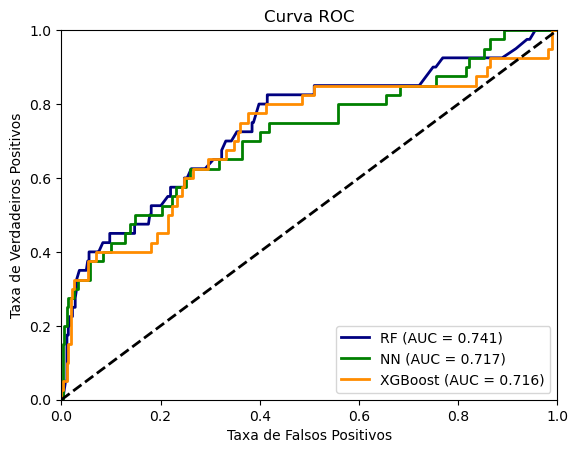

In [14]:
train(tipo = "BERTimbau", dimensoes = 768, arquivo = "BERT.xlsx", augment = True)

## Petrolês híbrido 100 dimensões

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês H100   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          345   14
1           23   17 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.94      0.96      0.95       359
           1       0.55      0.42      0.48        40

    accuracy                           0.91       399
   macro avg       0.74      0.69      0.71       399
weighted avg       0.90      0.91      0.90       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8564
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s 1m

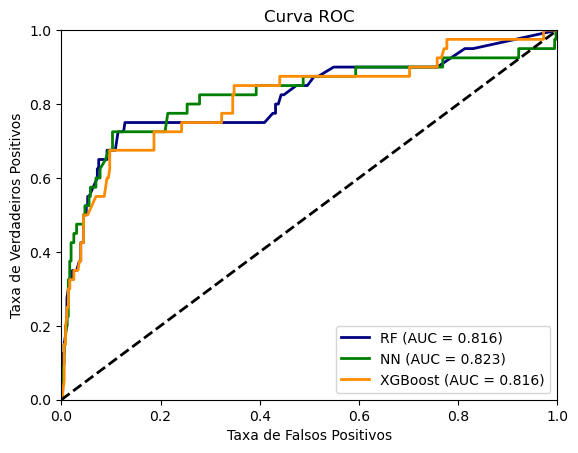

In [15]:
train(tipo = "Petrolês H100", dimensoes = 100, arquivo = "petroles.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês H100   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          322   37
1           14   26 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.96      0.90      0.93       359
           1       0.41      0.65      0.50        40

    accuracy                           0.87       399
   macro avg       0.69      0.77      0.72       399
weighted avg       0.90      0.87      0.88       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.5548 - accuracy: 0.7090
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.8053
Epoch 3/10
90/90 [==============================] - 0s 1ms

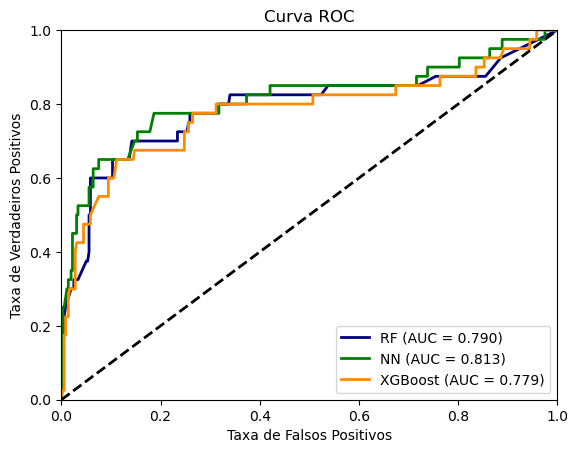

In [16]:
train(tipo = "Petrolês H100", dimensoes = 100, arquivo = "petroles.xlsx", augment = True)

## Petrolês O&G 100 dimensões

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês O&G 100   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          346   13
1           25   15 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.93      0.96      0.95       359
           1       0.54      0.38      0.44        40

    accuracy                           0.90       399
   macro avg       0.73      0.67      0.69       399
weighted avg       0.89      0.90      0.90       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3757 - accuracy: 0.8746
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3049 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s

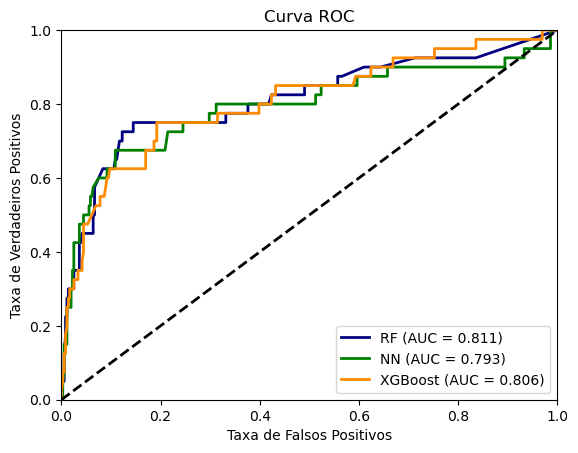

In [17]:
train(tipo = "Petrolês O&G 100", dimensoes = 100, arquivo = "petroles_o&g_100.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês O&G 100   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          332   27
1           17   23 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.95      0.92      0.94       359
           1       0.46      0.57      0.51        40

    accuracy                           0.89       399
   macro avg       0.71      0.75      0.72       399
weighted avg       0.90      0.89      0.90       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.5955 - accuracy: 0.6741
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7896
Epoch 3/10
90/90 [==============================] - 0s 

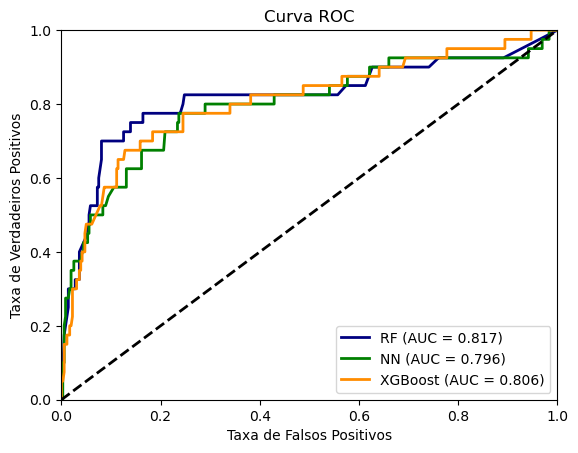

In [18]:
train(tipo = "Petrolês O&G 100", dimensoes = 100, arquivo = "petroles_o&g_100.xlsx", augment = True)

## Petrolês O&G 300 dimensões

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês O&G 300   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          344   15
1           25   15 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.93      0.96      0.95       359
           1       0.50      0.38      0.43        40

    accuracy                           0.90       399
   macro avg       0.72      0.67      0.69       399
weighted avg       0.89      0.90      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3439 - accuracy: 0.8997
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 0.2944 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s

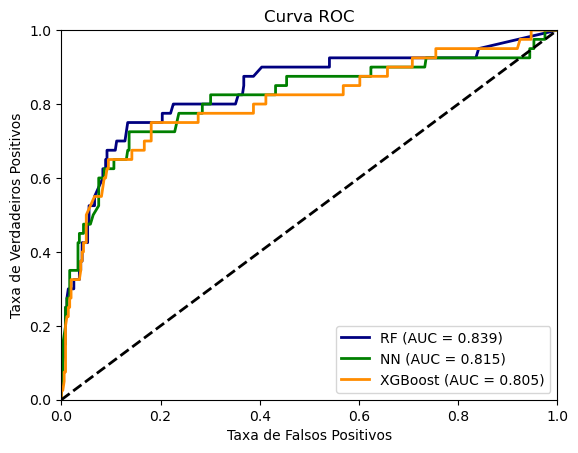

In [19]:
train(tipo = "Petrolês O&G 300", dimensoes = 300, arquivo = "petroles_o&g_300.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 Petrolês O&G 300   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          331   28
1           15   25 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.96      0.92      0.94       359
           1       0.47      0.62      0.54        40

    accuracy                           0.89       399
   macro avg       0.71      0.77      0.74       399
weighted avg       0.91      0.89      0.90       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.5549 - accuracy: 0.7073
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4203 - accuracy: 0.8161
Epoch 3/10
90/90 [==============================] - 0s 

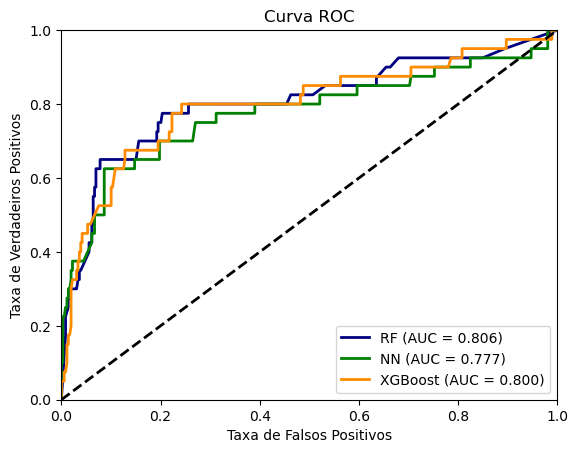

In [20]:
train(tipo = "Petrolês O&G 300", dimensoes = 300, arquivo = "petroles_o&g_300.xlsx", augment = True)

## SBERT v1

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 SBERT v1   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          352    7
1           31    9 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.92      0.98      0.95       359
           1       0.56      0.23      0.32        40

    accuracy                           0.90       399
   macro avg       0.74      0.60      0.64       399
weighted avg       0.88      0.90      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 0.4145 - accuracy: 0.8909
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s 2ms/ste

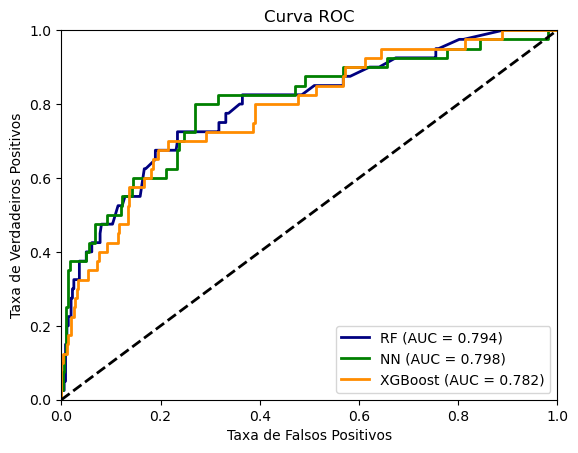

In [21]:
train(tipo = "SBERT v1", dimensoes = 512, arquivo = "sbert_v1.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 SBERT v1   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          343   16
1           24   16 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.93      0.96      0.94       359
           1       0.50      0.40      0.44        40

    accuracy                           0.90       399
   macro avg       0.72      0.68      0.69       399
weighted avg       0.89      0.90      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.7045
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7718
Epoch 3/10
90/90 [==============================] - 0s 1ms/step

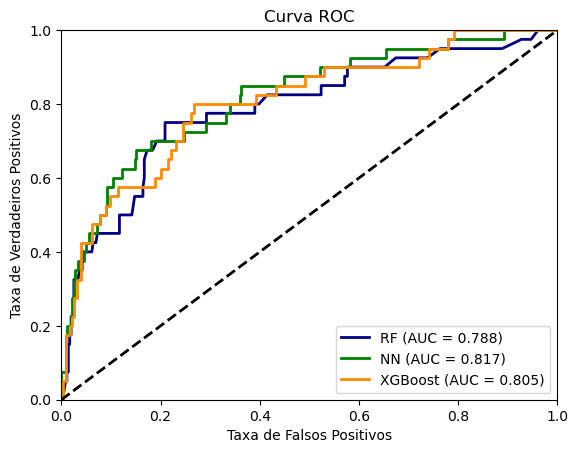

In [22]:
train(tipo = "SBERT v1", dimensoes = 512, arquivo = "sbert_v1.xlsx", augment = True)

## SBERT v2

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 SBERT v2   RF   False 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          353    6
1           30   10 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.92      0.98      0.95       359
           1       0.62      0.25      0.36        40

    accuracy                           0.91       399
   macro avg       0.77      0.62      0.65       399
weighted avg       0.89      0.91      0.89       399
 ---------------------------------------------------------------
Epoch 1/10
50/50 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.8972
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 0.3104 - accuracy: 0.8984
Epoch 3/10
50/50 [==============================] - 0s 1ms/ste

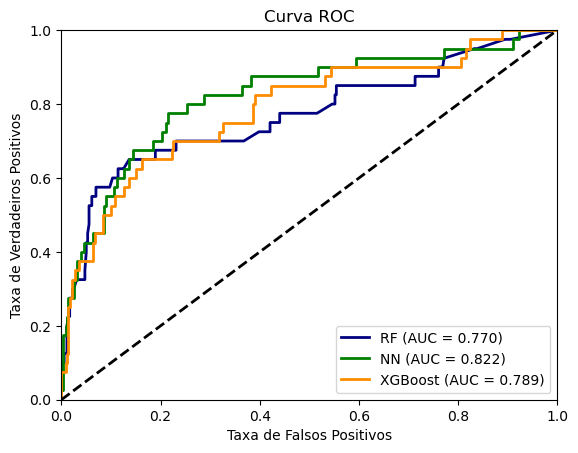

In [23]:
train(tipo = "SBERT v2", dimensoes = 512, arquivo = "sbert_v2.xlsx", augment = False)

C:\Users\UQBU\AppData\Local\Temp\ipykernel_36736\1537069448.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fun.fit(X_train_fun, y_train_fun)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
 SBERT v2   RF   True 
 ---------------------------------------------------------------
Matriz de confusão

 Predicted  0.0  1.0
Actual             
0          345   14
1           25   15 
 ---------------------------------------------------------------
Relatório de classificação

               precision    recall  f1-score   support

           0       0.93      0.96      0.95       359
           1       0.52      0.38      0.43        40

    accuracy                           0.90       399
   macro avg       0.72      0.67      0.69       399
weighted avg       0.89      0.90      0.90       399
 ---------------------------------------------------------------
Epoch 1/10
90/90 [==============================] - 0s 1ms/step - loss: 0.6110 - accuracy: 0.6800
Epoch 2/10
90/90 [==============================] - 0s 1ms/step - loss: 0.4920 - accuracy: 0.7729
Epoch 3/10
90/90 [==============================] - 0s 1ms/step

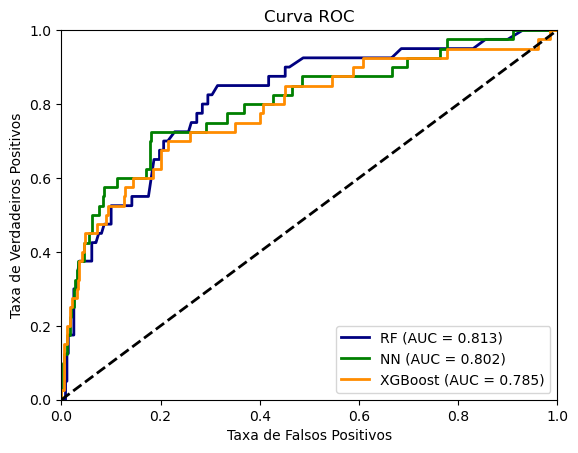

In [24]:
train(tipo = "SBERT v2", dimensoes = 512, arquivo = "sbert_v2.xlsx", augment = True)